# Validation of Catalytic Potential Models
All models are reconstructed based on the information from Yurkovich et al., “Network-Level Allosteric Effects Are Elucidated by Detailing How Ligand-Binding Events Modulate Utilization of Catalytic Potentials.”

__URL:__ https://doi.org/10.1371/journal.pcbi.1006356

## Setup
#### Import packages

In [1]:
from os import path 

# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import roadrunner as rr

import mass
from mass import MassConfiguration, Simulation, MassSolution
from mass.io import json
from mass.visualization import plot_time_profile, plot_phase_portrait

print("MASSpy version: " + mass.__version__)

Using license file /Users/zhaiman/opt/licenses/gurobi.lic
Academic license - for non-commercial use only
MASSpy version: 0.1.0


#### Set configurations

In [2]:
MASSCONFIGURATION = MassConfiguration()

MASSCONFIGURATION.decimal_precision = 12

# Configure the roadrunner options to prevent excessive logging output and increase performance
rr.Config.setValue(
    rr.Config.ROADRUNNER_DISABLE_PYTHON_DYNAMIC_PROPERTIES, False)
rr.Config.setValue(rr.Config.MAX_OUTPUT_ROWS, 1e6)

## Load Models

In [3]:
# Function to load a model 
def load_model(model_id):
    filename = model_id + ".json"
    filepath = path.realpath(path.join("CS1_data", "models", filename))
    model = json.load_json_model(filepath)
    return model

In [4]:
model_ids = [
    "Glycolysis", 
    "Glycolysis_Hb",
    "Glycolysis_PFK",
    "Glycolysis_PYK",
    "Glycolysis_Hb_HEX1",
    "Glycolysis_Hb_PFK",
    "Glycolysis_Hb_PYK",
    "Glycolysis_PFK_PYK",
    "Glycolysis_Hb_PFK_PYK",
    "Glycolysis_Hb_HEX1_PFK",
    "Glycolysis_Hb_HEX1_PYK",
    "Glycolysis_FKRM",
]

models = list(map(load_model, model_ids))
simulations = [Simulation(model, verbose=True) for model in models]

Successfully loaded MassModel 'Glycolysis' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_PFK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_PYK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_PFK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_PYK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_PFK_PYK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_PFK_PYK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1_PFK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_Hb_HEX1_PYK' into RoadRunner.
Successfully loaded MassModel 'Glycolysis_FKRM' into RoadRunner.


## Reproduce Figures
### Define functions for catalytic potential

In [5]:
def make_energy_charge(conc_sol):
    occ = 2 * conc_sol.atp_c + conc_sol.adp_c
    cap = 2 * conc_sol.atp_c + 2 * conc_sol.adp_c + 2 * conc_sol.amp_c
    return  occ / cap

def make_active_fraction(conc_sol, enzyme_module):
    active = enzyme_module.enzyme_module_forms_categorized.get_by_id(
        enzyme_module.id + "_Active")
    active = np.array(sum([conc_sol[m.id] for m in active.members]))
    total = np.array(sum([conc_sol[m.id] for m in enzyme_module.enzyme_module_forms]))
    return active / total

### Figures from Main Text
#### Figure 2

Simulating Glycolysis_Hb_HEX1 with 50% increase
Simulating Glycolysis_Hb_HEX1 with 15% decrease
Finished for Glycolysis_Hb_HEX1
Simulating Glycolysis_Hb_PFK with 50% increase
Simulating Glycolysis_Hb_PFK with 15% decrease
Finished for Glycolysis_Hb_PFK
Simulating Glycolysis_Hb_PYK with 50% increase
Simulating Glycolysis_Hb_PYK with 15% decrease
Finished for Glycolysis_Hb_PYK


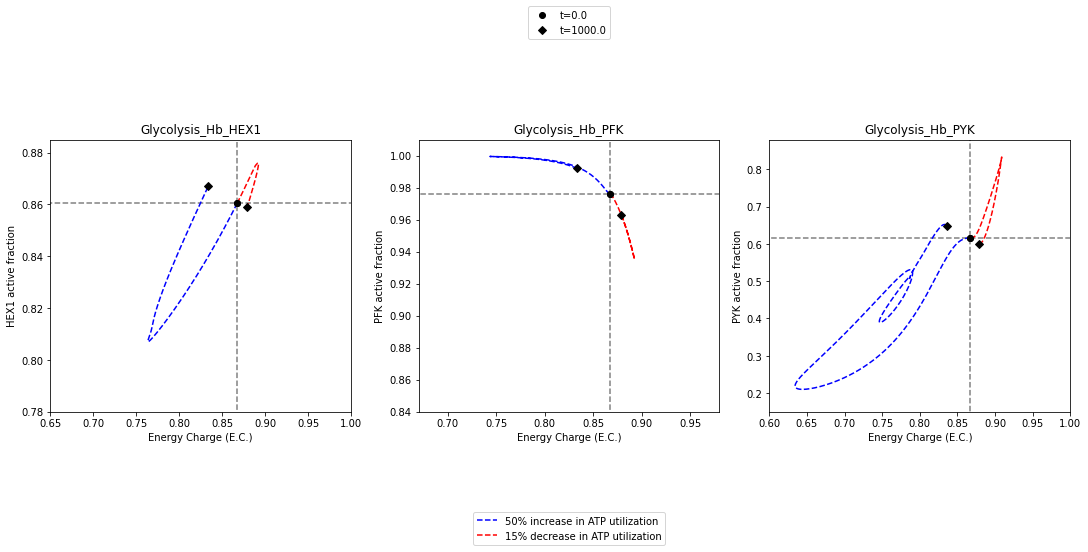

In [6]:
tfinal = 1000
npoints = tfinal*5 + 1
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6), constrained_layout=True)
axes = axes.flatten()

xlims = [(0.65, 1.), (0.67, 0.98), (0.6, 1.)]
ylims = [(0.78, 0.885), (0.84, 1.01), (0.15, 0.88)]
colors = ["blue", "red"]

# Initialize counter
i = 0
for model, sim in zip(models, simulations):
    if model.id not in ["Glycolysis_Hb_HEX1",
                        "Glycolysis_Hb_PFK",
                        "Glycolysis_Hb_PYK"]:
        continue
    ax = axes[i]
    # Get enzyme module
    enzyme_id = model.id.split("_")[-1]
    enzyme_module = model.enzyme_modules.get_by_id(enzyme_id)
    # Ensure model is in steady state
    conc_sol, flux_sol = sim.find_steady_state(model, strategy="simulate",
                                               update_values=True,
                                               decimal_precision=True,
                                               steps=1e5, tfinal=1e4)

    # Plot initial energy charge and active fractions
    conc_sol["Energy_Charge"] = make_energy_charge(conc_sol)
    ax.plot([conc_sol["Energy_Charge"], conc_sol["Energy_Charge"]], [0, 1.1],
            color="grey", linestyle="--")

    active_key = enzyme_id + " active fraction"
    conc_sol[active_key] = make_active_fraction(conc_sol, enzyme_module)
    ax.plot([0, 1.1], [conc_sol[active_key], conc_sol[active_key]],
            color="grey", linestyle="--")

    # Simulate with perturbations, use variable step size in solution output
    for j, perturbation in enumerate([{"kf_ATPM": "kf_ATPM * 1.5"}, {"kf_ATPM": "kf_ATPM * 0.85"}]):
        if j == 0:
            label = "50% increase"
        else:
            label = "15% decrease"

        # Set options for plot legends
        if i == 1:
            legend = [label + " in ATP utilization", "lower outside"]
            time_points_legend="upper outside"

        else:
            legend = None
            time_points_legend = None

        # Simulate model with percent change
        print(" ".join(("Simulating", model.id, "with", label)))
        conc_sol, flux_sol = sim.simulate(
            model, time=(0, tfinal, npoints),
            perturbations=perturbation)

        conc_sol[active_key] = make_active_fraction(conc_sol, enzyme_module)
        conc_sol["Energy_Charge"] = make_energy_charge(conc_sol)

        plot_phase_portrait(
            conc_sol, x="Energy_Charge", y=active_key, ax=ax, legend=legend,
            xlabel="Energy Charge (E.C.)", ylabel=active_key,
            xlim=xlims[i], ylim=ylims[i], title=model.id,
            color=colors[j], linestyle="--",
            annotate_time_points="endpoints",
            annotate_time_points_color=["black"],
            annotate_time_points_legend=time_points_legend)

    i += 1
    print("Finished for " + model.id)

#### Figure 4

Simulating Glycolysis_FKRM with 50% increase
Simulating Glycolysis_FKRM with 15% decrease


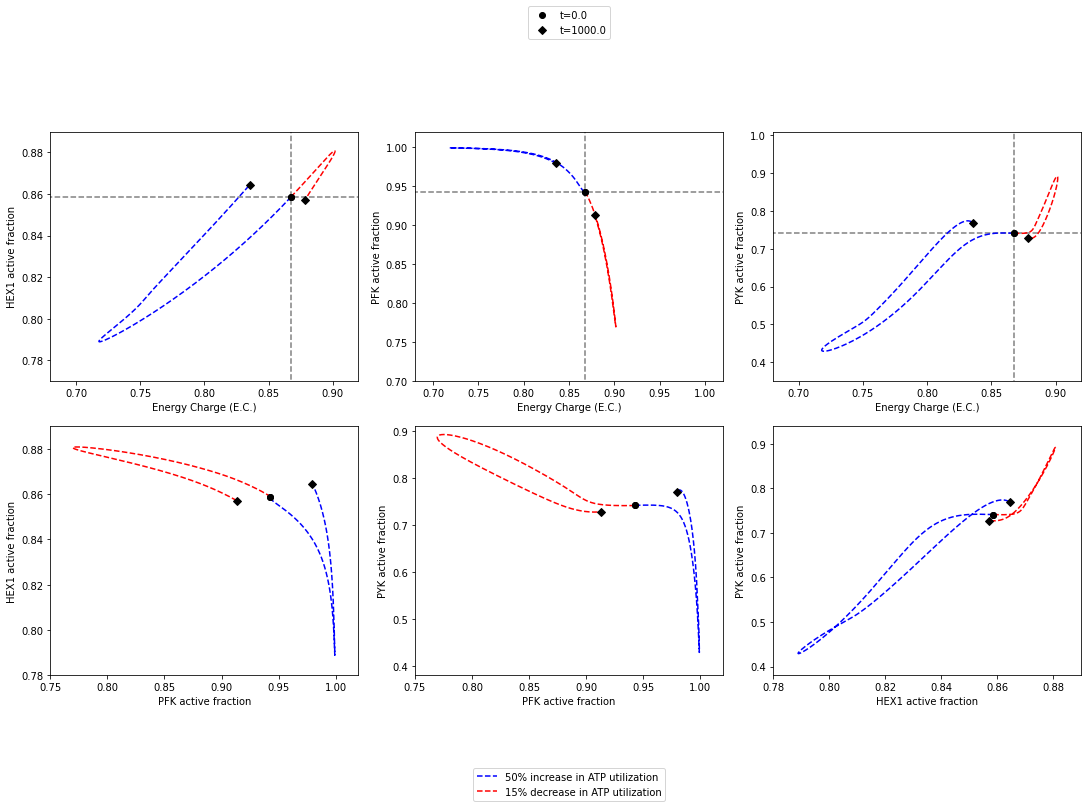

In [7]:
tfinal = 1000
npoints = tfinal*5 + 1
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 11),
                         constrained_layout=True)

i = 0
xlims = [(0.68, 0.92), (0.68, 1.02), (0.68, 0.92),
         (0.75, 1.02), (0.75, 1.02), (0.78, 0.89)]

ylims = [(0.77, 0.89), (0.70, 1.02), (0.35, 1.01),
         (0.78, 0.89), (0.38, 0.91), (0.38, 0.94)]

colors = ["blue", "red"]

for model, sim in zip(models, simulations):
    if model.id not in ["Glycolysis_FKRM"]:
        continue
    else:
        enzyme_ids = ["HEX1", "PFK", "PYK"]
    # Get enzyme modules
    HEX1 = model.enzyme_modules.get_by_id(enzyme_ids[0])
    PFK = model.enzyme_modules.get_by_id(enzyme_ids[1])
    PYK = model.enzyme_modules.get_by_id(enzyme_ids[2])

    # Plot initial energy charge and active fractions
    conc_sol, flux_sol = sim.find_steady_state(model, strategy="simulate",
                                               update_values=True,
                                               decimal_precision=True,
                                               steps=1e5, tfinal=1e4)
    conc_sol["Energy_Charge"] = make_energy_charge(conc_sol)
    conc_sol["HEX1_active_fraction"] = make_active_fraction(conc_sol, HEX1)
    conc_sol["PFK_active_fraction"] = make_active_fraction(conc_sol, PFK)
    conc_sol["PYK_active_fraction"] = make_active_fraction(conc_sol, PYK)
    for i, enzyme_id in enumerate(enzyme_ids):
        # Plot energy charge
        axes[0][i].plot([conc_sol["Energy_Charge"], conc_sol["Energy_Charge"]], [0, 1.1],
                        color="grey", linestyle="--")
        # Plot active fraction
        active_key = enzyme_id + "_active_fraction"
        axes[0][i].plot([0, 1.1], [conc_sol[active_key], conc_sol[active_key]],
                        color="grey", linestyle="--")
    
    # Simulate with perturbations
    for j, perturbation in enumerate([{"kf_ATPM": "kf_ATPM * 1.5"}, {"kf_ATPM": "kf_ATPM * 0.85"}]):
        if j == 0:
            label = "50% increase"
        else:
            label = "15% decrease"
            
        # Simulate model with percent change and make pooled solutions
        print(" ".join(("Simulating", model.id, "with", label)))
        conc_sol, flux_sol = sim.simulate(
            model, time=(0, tfinal, npoints),
            perturbations=perturbation)
        conc_sol["Energy_Charge"] = make_energy_charge(conc_sol)
        conc_sol["HEX1_active_fraction"] = make_active_fraction(conc_sol, HEX1)
        conc_sol["PFK_active_fraction"] = make_active_fraction(conc_sol, PFK)
        conc_sol["PYK_active_fraction"] = make_active_fraction(conc_sol, PYK)

        # Plot energy charge vs active fraction for each enzyme.
        for i, enzyme_id in enumerate(enzyme_ids):
            if i == 1:
                time_points_legend = "upper outside"
            else:
                time_points_legend = None

            active_key = enzyme_id + "_active_fraction"
            plot_phase_portrait(
                conc_sol, x="Energy_Charge", y=active_key, ax=axes[0][i],
                xlabel="Energy Charge (E.C.)", ylabel=active_key.replace("_", " "),
                xlim=xlims[i], ylim=ylims[i],
                color=colors[j], linestyle="--",
                annotate_time_points="endpoints",
                annotate_time_points_color=["black"],
                annotate_time_points_legend=time_points_legend)

        # Plot active fractions against one another
        for i, (x, y) in enumerate(zip(["PFK_active_fraction", "PFK_active_fraction", "HEX1_active_fraction"],
                                       ["HEX1_active_fraction", "PYK_active_fraction", "PYK_active_fraction"])):
            if i == 1:
                legend = [label + " in ATP utilization", "lower outside"]
            else:
                legend = None

            plot_phase_portrait(
                conc_sol, x=x, y=y, ax=axes[1][i], legend=legend,
                xlabel=x.replace("_", " "), ylabel=y.replace("_", " "),
                xlim=xlims[i + 3], ylim=ylims[i + 3],
                color=colors[j], linestyle="--",
                annotate_time_points="endpoints",
                annotate_time_points_color=["black"])

### Supplemental Figures
#### Figure A

Finished for Glycolysis
Finished for Glycolysis_Hb
Finished for Glycolysis_PFK
Finished for Glycolysis_PYK
Finished for Glycolysis_Hb_HEX1
Finished for Glycolysis_Hb_PFK
Finished for Glycolysis_Hb_PYK
Finished for Glycolysis_PFK_PYK
Finished for Glycolysis_Hb_PFK_PYK
Finished for Glycolysis_Hb_HEX1_PFK
Finished for Glycolysis_Hb_HEX1_PYK
Finished for Glycolysis_FKRM


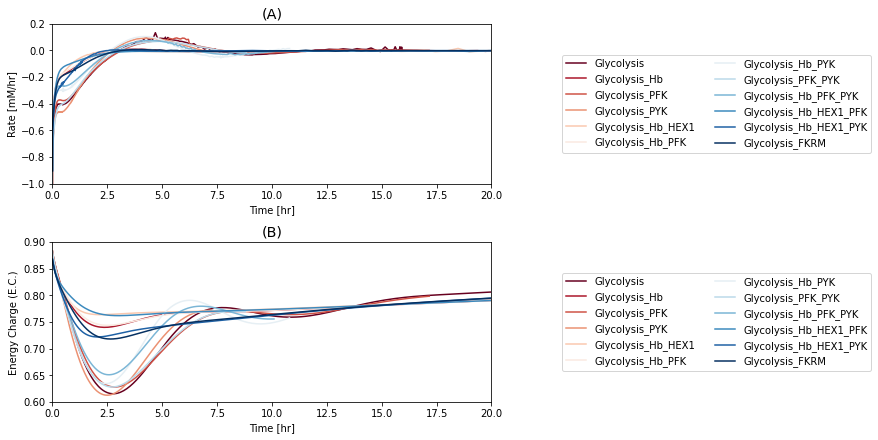

In [8]:
tfinal = 20
npoints = tfinal*25 + 1
colors = mpl.cm.RdBu(np.linspace(0, 1, len(models)), alpha=0.5)
colors = [mpl.colors.to_hex(c) for c in colors]
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 6),
                               constrained_layout=True)

for i, (model, sim) in enumerate(zip(models, simulations)):
    # Simulate model
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, tfinal, npoints),
        perturbations={"kf_ATPM": "kf_ATPM * 1.5"})
    # Get ATP metabolite
    atp_c = model.metabolites.get_by_id("atp_c")
    # Get reactions that utilize ATP
    atp_reactions = list(atp_c.reactions)
    production = []
    consumption = []
    for rxn in atp_reactions:
        if atp_c in rxn.products:
            production.append(rxn)
        else:
            consumption.append(rxn)
    # Create solution for net rate of ATP usage
    flux_sol.make_aggregate_solution(
        "Net_ATP_Usage_Rate", variables=production + consumption,
        equation="({0}) - ({1})".format(
            " + ".join([r.id for r in production]),
            " + ".join([r.id for r in consumption])))
    plot_time_profile(
        flux_sol, observable="Net_ATP_Usage_Rate", ax=ax1,
        legend=(model.id, "right outside"), plot_function="plot",
        xlabel="Time [hr]", ylabel="Rate [mM/hr]",
        xlim=(0, tfinal), ylim=(-1, 0.2),
        title=("(A)", {"size": "x-large"}), color=colors[i])

    # Create solution for energy charge
    conc_sol["Energy_Charge"] = make_energy_charge(conc_sol)
    plot_time_profile(
        conc_sol, observable="Energy_Charge", ax=ax2,
        legend=(model.id, "right outside"), plot_function="plot",
        xlabel="Time [hr]", ylabel="Energy Charge (E.C.)",
        xlim=(0, tfinal), ylim=(0.6, 0.9),
        title=("(B)", {"size": "x-large"}), color=colors[i])
    print("Finished for " + model.id)

#### Figure B

Finished for Glycolysis_PFK
Finished for Glycolysis_Hb_PFK_PYK
Finished for Glycolysis_Hb_HEX1_PFK


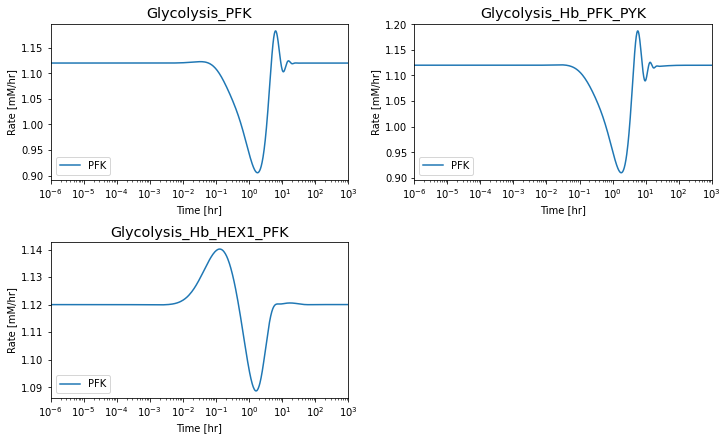

In [9]:
tfinal = 1000
npoints = tfinal*5 + 1
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6),
                         constrained_layout=True)
axes = axes.flatten()
fig.delaxes(axes[-1])

i = 0
for model, sim in zip(models, simulations):
    if model.id not in ["Glycolysis_PFK", "Glycolysis_Hb_PFK_PYK", "Glycolysis_Hb_HEX1_PFK"]:
        continue
    # Simulate model
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, tfinal, npoints),
        perturbations={"kf_ATPM": "kf_ATPM * 1.5"})
    try:
        reactions = model.reactions.get_by_any([
            "PFK_R03", "PFK_R13", "PFK_R23", "PFK_R33", "PFK_R43"])
        flux_sol.make_aggregate_solution(
            "PFK", variables=reactions,
            equation=" + ".join([r.id for r in reactions]))
        observable = "PFK"
    except KeyError:
        observable = model.reactions.get_by_id("PFK").id
    plot_time_profile(
        flux_sol, observable=observable, ax=axes[i],
        legend="lower left", plot_function="semilogx",
        xlabel="Time [hr]", ylabel="Rate [mM/hr]",
        xlim=(1e-6, tfinal), 
        title=(model.id, {"size": "x-large"}))
    i += 1
    print("Finished for " + model.id)

#### Figure D

Simulating Glycolysis_Hb_PYK with 50% increase
Simulating Glycolysis_Hb_PYK with 15% decrease
Simulating Glycolysis_FKRM with 50% increase
Simulating Glycolysis_FKRM with 15% decrease


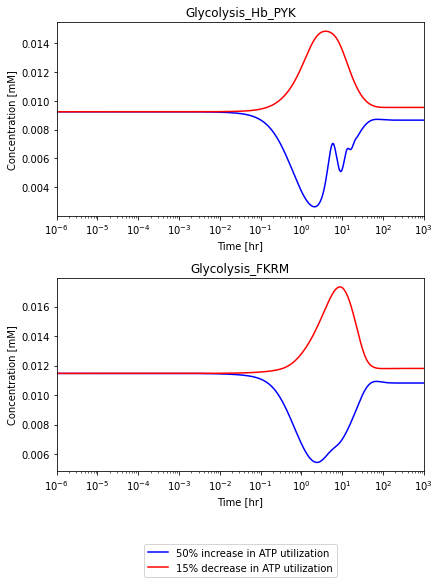

In [10]:
tfinal = 1000
npoints = tfinal*10 + 1
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8),
                         constrained_layout=True)
axes = axes.flatten()
colors = ["blue", "red"]

i = 0
for model, sim in zip(models, simulations):
    if model.id not in ["Glycolysis_Hb_PYK", "Glycolysis_FKRM"]:
        continue
    # Use a variable step size for the solution output
    for j, perturbation in enumerate([{"kf_ATPM": "kf_ATPM * 1.5"}, {"kf_ATPM": "kf_ATPM * 0.85"}]):
        if j == 0:
            label = "50% increase"
        else:
            label = "15% decrease"
            
        # Simulate model with perturbation
        print("Simulating " + model.id + " with " + label)
        conc_sol, flux_sol = sim.simulate(
            model, time=(0, tfinal, npoints),
            perturbations=perturbation)
        
        if i == 1:
            legend = [label + " in ATP utilization", "lower outside"]
        else:
            legend = None
        plot_time_profile(conc_sol, observable="fdp_c", ax=axes[i],
                          legend=legend, plot_function="semilogx",
                          color=colors[j], xlim=(1e-6, tfinal),
                          xlabel= "Time [hr]", ylabel="Concentration [mM]",
                          title=model.id)
    i += 1

#### Figure F

In [11]:
from mass.test import create_test_model

In [12]:
WCRBC_MA = create_test_model("WholeCellRBC_MA_Rates")
WCRBC_MA_sim = Simulation(WCRBC_MA, verbose=True)

Successfully loaded MassModel 'WholeCellRBC_MA_Rates' into RoadRunner.


Finished for Glycolysis_Hb
Finished for Glycolysis_Hb_HEX1
Finished for Glycolysis_Hb_PFK
Finished for Glycolysis_Hb_PYK
Finished for Glycolysis_FKRM
Finished for WholeCellRBC_MA_Rates


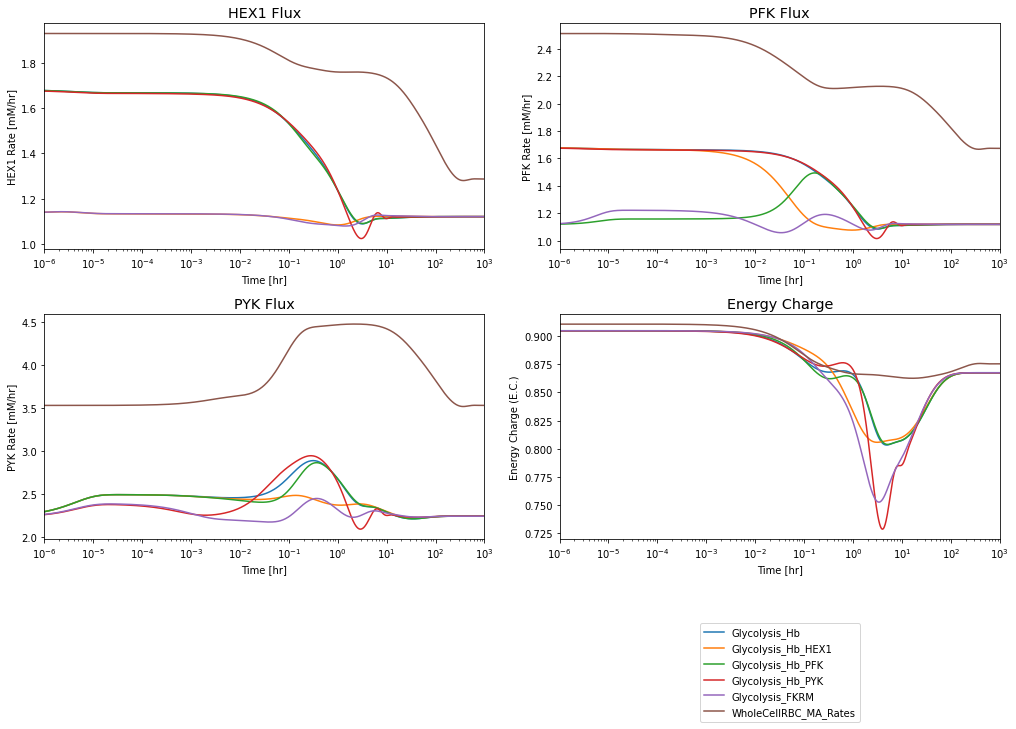

In [13]:
tfinal = 1000
npoints = tfinal*10 + 1
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10),
                         constrained_layout=True)
axes = axes.flatten()

models += [WCRBC_MA]
simulations += [WCRBC_MA_sim]
for model, sim in zip(models, simulations):
    if model.id not in ["Glycolysis_Hb",
                        "Glycolysis_Hb_HEX1",
                        "Glycolysis_Hb_PFK",
                        "Glycolysis_Hb_PYK",
                        "Glycolysis_FKRM",
                        "WholeCellRBC_MA_Rates"]:
        continue
    # Simulate model
    conc_sol, flux_sol = sim.simulate(
        model, time=(0, tfinal, npoints),
        perturbations={"atp_c": "atp_c * 1.5"})
    # Flux through HEX1
    try:
        reactions = model.reactions.get_by_any(["HEX1_8"])
        flux_sol.make_aggregate_solution(
            "HEX1", variables=reactions,
            equation=" + ".join([r.id for r in reactions]))
        observable = "HEX1"
    except KeyError:
        observable = model.reactions.get_by_id("HEX1").id
    plot_time_profile(
        flux_sol, observable=observable, ax=axes[0],
        plot_function="semilogx",
        xlabel="Time [hr]", ylabel=observable + " Rate [mM/hr]",
        xlim=(1e-6, tfinal),
        title=("HEX1 Flux", {"size": "x-large"}))

    # Flux through PFK
    try:
        reactions = model.reactions.get_by_any([
            "PFK_R03", "PFK_R13", "PFK_R23", "PFK_R33", "PFK_R43"])
        flux_sol.make_aggregate_solution(
            "PFK", variables=reactions,
            equation=" + ".join([r.id for r in reactions]))
        observable = "PFK"
    except KeyError:
        observable = model.reactions.get_by_id("PFK").id
    plot_time_profile(
        flux_sol, observable=observable, ax=axes[1],
        plot_function="semilogx",
        xlabel="Time [hr]", ylabel=observable + " Rate [mM/hr]",
        xlim=(1e-6, tfinal),
        title=("PFK Flux", {"size": "x-large"}))
        
    # Flux through PYK
    try:
        reactions = model.reactions.get_by_any([
            "PYK_R05", "PYK_R15", "PYK_R25", "PYK_R35", "PYK_R45"])
        flux_sol.make_aggregate_solution(
            "PYK", variables=reactions,
            equation=" + ".join([r.id for r in reactions]))
        observable = "PYK"
    except KeyError:
        observable = model.reactions.get_by_id("PYK").id
    plot_time_profile(
        flux_sol, observable=observable, ax=axes[2],
        plot_function="semilogx",
        xlabel="Time [hr]", ylabel=observable + " Rate [mM/hr]",
        xlim=(1e-6, tfinal),
        title=("PYK Flux", {"size": "x-large"}))
    
    # Energy Charge
    conc_sol["Energy_Charge"] = make_energy_charge(conc_sol)
    plot_time_profile(
        conc_sol, observable="Energy_Charge", ax=axes[3],
        legend=(model.id, "lower outside"),
        plot_function="semilogx",
        xlabel="Time [hr]", ylabel="Energy Charge (E.C.)",
        xlim=(1e-6, tfinal),
        title=("Energy Charge", {"size": "x-large"}))
    print("Finished for " + model.id)